# Using NP4VTT: Local logit

In this notebook, we show how to use a local (weighted) logit to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the local logit, and Pandas to load the dataset:

In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
import numpy as np
from py_np4vtt.data_format import Vars
from py_np4vtt.model_loclogit import ModelLocLogit, ConfigLocLogit
from py_np4vtt.data_import import make_modelarrays, compute_descriptives

Now we read the CSV file:

In [3]:
df = pd.read_table('../data/Norway2009VTT_demodata.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL`: Travel cost of alternatives 1 [NOK]
* `CostR`: Travel cost of alternatives 2 [NOK]
* `TimeL`: Travel time of alternatives 1 [minutes]
* `TimeR`: Travel time of alternatives 2 [minutes]

NP4VTT detects automatically the _slow and cheap_ and _fast and expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Change currency of travel time to euros and change unit of travel time to hours

In [4]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [5]:
columnarrays = {
    Vars.Id: 'RespID',
    Vars.ChosenAlt: 'Chosen',
    Vars.Cost1: 'CostL',
    Vars.Cost2: 'CostR',
    Vars.Time1: 'TimeL',
    Vars.Time2: 'TimeR',
}

And we create the required arrays:

In [6]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [7]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 10.2977
Minimum of BVTT: 0.6667
Maximum of BVTT: 113.5632


## Step 3: Configure the local logit

The local logit requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.

Based on the descriptive statistics, we create a VTT grid in the range of 0 (minimum) and 100 (maximum), with 20 support points. Hence, the VTT grid is defined on intervals of 5.

The function `ConfigLocLogit` takes the configuration parameters of the local logit and creates an object that is used by the optimisation routine:

In [8]:
config = ConfigLocLogit(minimum=0, maximum=100, supportPoints=21)

Now, we create the Local logit object that contains the configuration parameters and the data arrays.

In [9]:
loclogit = ModelLocLogit(config, model_arrays)

Created a VTT grid of 21 points between 0 and 100.
Distance between points of the VTT grid is 5.0


`ModelLocLogit` creates the following objects that can be accessed using the 'dot' notation (i.e., `ModelLocLogit.`_object_):

* `vtt_grid`: VTT grid as specified in `ConfigLocLogit`
* `vtt_mid`: VTT mid points, based in the VTT grid. The first point of the grid is zero, whereas the last point is equal to the last point of the original VTT grid.

In [10]:
vtt_grid = loclogit.vtt_grid
vtt_grid

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [11]:
vtt_mid = loclogit.vtt_mid
vtt_mid

array([  0. ,   2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,
        42.5,  47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,
        87.5,  92.5,  97.5, 100. ])

## Step 4: Estimate a local logit

Once the local logit object is initialised, the `run` method starts the optimisation process:

In [12]:
p, vtt, ll = loclogit.run()

The estimated model returns the following information:

* `p:` The estimates of the cumulative probability function (CDF) evaluated at each interval of the VTT grid. The first point is always zero while the last point is always equal to the second last for compatibility with plots.
* `vtt`: The estimated VTT for each respondent, based in the estimated probabilities and the VTT grid.
* `ll:` Value of the likelihood function in the optimum.

The following lines present the estimated results:

In [13]:
# Create dataframe
grid_range = ['(' + str(vtt_grid[i]) + ' - ' + str(vtt_grid[i+1]) + ')' for i in range(vtt_grid.shape[0]-1)]
results = pd.DataFrame(np.c_[grid_range,np.round(p[1:-1],4)],columns=['VTT','Prob.'],index=np.arange(len(vtt_grid[1:])))

print('Estimation results:\n')
print('Final log-likelihood: ' + str(round(ll,2)))
print('\nEstimated Cumulative probability:')
print(results)

Estimation results:

Final log-likelihood: -27547.25

Estimated Cumulative probability:
               VTT   Prob.
0      (0.0 - 5.0)  0.0766
1     (5.0 - 10.0)  0.3833
2    (10.0 - 15.0)  0.6066
3    (15.0 - 20.0)  0.7338
4    (20.0 - 25.0)  0.8041
5    (25.0 - 30.0)  0.8343
6    (30.0 - 35.0)  0.8555
7    (35.0 - 40.0)  0.8819
8    (40.0 - 45.0)  0.9106
9    (45.0 - 50.0)  0.9115
10   (50.0 - 55.0)  0.9261
11   (55.0 - 60.0)  0.9334
12   (60.0 - 65.0)  0.9216
13   (65.0 - 70.0)  0.9235
14   (70.0 - 75.0)  0.9254
15   (75.0 - 80.0)  0.9509
16   (80.0 - 85.0)  0.9553
17   (85.0 - 90.0)  0.9506
18   (90.0 - 95.0)  0.9215
19  (95.0 - 100.0)  0.9464


## Step 5: Visualising the VTT distribution

We create the empirical Cumulative Density Function plot of the VTT distribution. For easy interpretation, we create a histogram from the CDF. 
We use matplotlib for this:

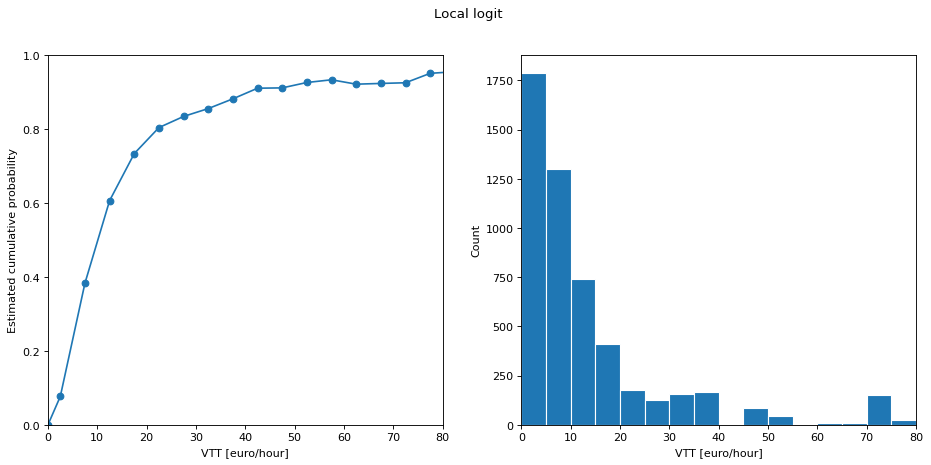

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
ax[0].plot(vtt_mid,p,marker='o')
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Estimated cumulative probability')

# Plot histogram
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(vtt, bins = vtt_grid,edgecolor="white")
fig.suptitle('Local logit')
plt.savefig('outcomes/loclogit.png')
plt.show()